<a href="https://colab.research.google.com/github/sooominie/GDGoCewha_AI/blob/main/week3/titanic_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 머신러닝
이번주 세션은 머신러닝에 대해 자세히 학습하고 타이타닉 데이터로 실습을 진행했습니다.
학습 내용은 리드미에 추가했고 세션 실습 코드에 아래 세가지 내용을 더 추가해 공부하였습니다.

1)baseline vs boosting 성능 비교
2)ROC Curve + AUC 시각화

3)XGBoost hyperparameter tuning + cross-validation


<학습목표>
- feature engineering을 적용한 모델 성능 향상
- baseline 모델과 boosting 모델 비교
- 다양한 평가 지표 실습
- hyperparameter tuning과 cross-validation적용하기

In [ ]:
!pip install xgboost

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

from xgboost import XGBClassifier

In [ ]:
df = pd.read_csv('/content/titanic.csv')
df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


In [ ]:
df = df.drop(columns=['Cabin'])
df = df.dropna(subset=['Embarked'])

df.isnull().sum()


,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


## feature engineering

In [ ]:
#결측치 처리
df['Age'] = df['Age'].fillna(df['Age'].median())
#범주형 변수 처리
df['Sex'] = LabelEncoder().fit_transform(df['Sex'])
#새로운 feature 생성
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C,2
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,S,2
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,S,1


In [ ]:
df.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


In [ ]:
#스케일링
scaler = StandardScaler()
X = df.drop(['Survived','Name', 'Ticket','Embarked'], axis=1)
y = df['Survived']
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,FamilySize
0,-1.732505,0.825209,0.735342,-0.563674,0.431350,-0.474326,-0.500240,0.057853
1,-1.728611,-1.572211,-1.359911,0.669217,0.431350,-0.474326,0.788947,0.057853
2,-1.724718,0.825209,-1.359911,-0.255451,-0.475199,-0.474326,-0.486650,-0.561804
3,-1.720825,-1.572211,-1.359911,0.438050,0.431350,-0.474326,0.422861,0.057853
4,-1.716931,0.825209,0.735342,0.438050,-0.475199,-0.474326,-0.484133,-0.561804


## baseline 모델과 boosting 성능 비교

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
models = {
    "Logistic": LogisticRegression(max_iter=500),
    "DecisionTree": DecisionTreeClassifier()
}

def evaluate(model):
    pred = model.predict(X_test)
    return {
        "Accuracy": accuracy_score(y_test, pred),
        "Precision": precision_score(y_test, pred),
        "Recall": recall_score(y_test, pred),
        "F1": f1_score(y_test, pred)
    }

for name, model in models.items():
    model.fit(X_train, y_train)
    print(name, evaluate(model))


Logistic {'Accuracy': 0.7921348314606742, 'Precision': 0.7162162162162162, 'Recall': 0.7681159420289855, 'F1': 0.7412587412587412}
DecisionTree {'Accuracy': 0.7696629213483146, 'Precision': 0.6891891891891891, 'Recall': 0.7391304347826086, 'F1': 0.7132867132867133}


In [ ]:
boost_models = {
    "AdaBoost": AdaBoostClassifier(n_estimators=100),
    "GradientBoosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(n_estimators=200, learning_rate=0.1)
}

for name, model in boost_models.items():
    model.fit(X_train, y_train)
    print(name, evaluate(model))


AdaBoost {'Accuracy': 0.8202247191011236, 'Precision': 0.7466666666666667, 'Recall': 0.8115942028985508, 'F1': 0.7777777777777778}
GradientBoosting {'Accuracy': 0.8202247191011236, 'Precision': 0.7605633802816901, 'Recall': 0.782608695652174, 'F1': 0.7714285714285715}
XGBoost {'Accuracy': 0.7808988764044944, 'Precision': 0.7272727272727273, 'Recall': 0.6956521739130435, 'F1': 0.7111111111111111}


##평가지표
- accuracy: 가장 흔히 사용
- precision: 모델이 true라고 분류한 것 중 실제 true의 비율
- recall: 실제 true인 것 중 모델이 true라고 예측한 비율
- F1 Score: precision과 recall의 조화평균
- ROC: 여러 임계값들을 기준으로 Recall-Fallout의 변화 시각화(curve가 왼쪽위에 가까울수록 모델의 성능이 좋음)
- AUC: ROC 그래프의 아래 면적값(1에 가까울 수록 좋은 모델)

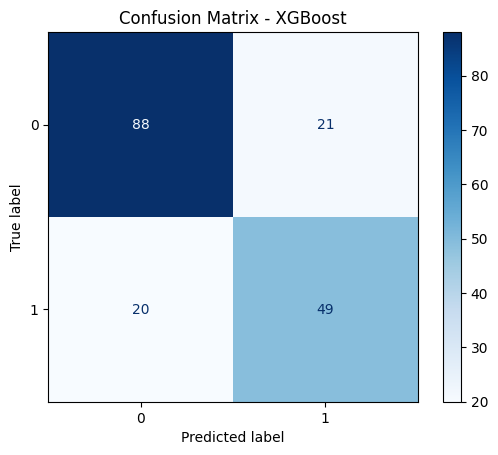

In [ ]:
#precision/recall
from sklearn.metrics import ConfusionMatrixDisplay

model = XGBClassifier()
model.fit(X_train, y_train)

disp = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap="Blues")
plt.title("Confusion Matrix - XGBoost")
plt.show()
